<a href="https://colab.research.google.com/github/so1rou/PD3-colab/blob/main/ResNet50_act.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# モジュールのインポート
from time import time
import numpy as np
import torch
import torch.nn as nn

import torchvision
import torchvision.transforms as transforms

import torchsummary

#ROC曲線作成用
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression

from keras.datasets import cifar10

colors = ['#de3838', '#007bc3', '#ffd12a']

# GPUの確認
use_cuda = torch.cuda.is_available()
print('Use CUDA:', use_cuda)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Use CUDA: True


In [ ]:
transform_train = transforms.Compose([transforms.RandomCrop(32, padding=1),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor()])
transform_test = transforms.Compose([transforms.ToTensor()])

train_data = torchvision.datasets.CIFAR10(root="./", train=True, transform=transform_train, download=True)
test_data = torchvision.datasets.CIFAR10(root="./", train=False, transform=transform_test, download=True)

classes = ('plane', 'car', 'bird', 'cat', 
'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified


In [ ]:
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super().__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(planes),
            nn.ReLU(inplace=True),
            nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(planes),
        )
        self.downsample = downsample
        self.relu = nn.ReLU(inplace=True)
        self.stride = stride

    def forward(self, x):
        residual = x
        out = self.convs(x)
        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super().__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(in_planes, planes, kernel_size=1, bias=False),
            nn.BatchNorm2d(planes),
            nn.ReLU(inplace=True),
            nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(planes),
            nn.ReLU(inplace=True),
            nn.Conv2d(planes, self.expansion * planes, kernel_size=1, bias=False),
            nn.BatchNorm2d(self.expansion * planes),
        )
        self.downsample = downsample
        self.relu = nn.ReLU(inplace=True)
        self.stride = stride

    def forward(self, x):
        residual = x
        out = self.convs(x)
        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

In [ ]:
class ResNetBasicBlock(nn.Module):
    def __init__(self, depth, n_class=10):
        super().__init__()
        # 指定した深さ（畳み込みの層数）でネットワークを構築できるかを確認
        assert (depth - 2) % 6 == 0, 'When use basicblock, depth should be 6n+2 (e.g. 20, 32, 44).'
        n_blocks = (depth - 2) // 6  # 1ブロックあたりのBasic Blockの数を決定

        self.inplanes = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = self._make_layer(16, n_blocks)
        self.layer2 = self._make_layer(32, n_blocks, stride=2)
        self.layer3 = self._make_layer(64, n_blocks, stride=2)

        self.avgpool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64 * BasicBlock.expansion, n_class)

    def _make_layer(self, planes, n_blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * BasicBlock.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * BasicBlock.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * BasicBlock.expansion),
            )

        layers = []
        layers.append(BasicBlock(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * BasicBlock.expansion
        for _ in range(0, n_blocks - 1):
            layers.append(BasicBlock(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


class ResNetBottleneck(nn.Module):
    def __init__(self, depth, n_class=10):
        super().__init__()
        # 指定した深さ（畳み込みの層数）でネットワークを構築できるかを確認
        assert (depth - 2) % 9 == 0, 'When use Bottleneck, depth should be 9n+2 (e.g. 47, 56, 110, 1199).'
        n_blocks = (depth - 2) // 9  # 1ブロックあたりのBasic Blockの数を決定

        self.inplanes = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = self._make_layer(16, n_blocks)
        self.layer2 = self._make_layer(32, n_blocks, stride=2)
        self.layer3 = self._make_layer(64, n_blocks, stride=2)

        self.avgpool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64 * Bottleneck.expansion, n_class)

    def _make_layer(self, planes, n_blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * Bottleneck.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * Bottleneck.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * Bottleneck.expansion),
            )

        layers = []
        layers.append(Bottleneck(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * Bottleneck.expansion
        for _ in range(0, n_blocks - 1):
            layers.append(Bottleneck(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [ ]:
#事前学習済みモデルインストール
model = torchvision.models.resnet50(pretrained=True).to(device)
if use_cuda:
    model.cuda()

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# モデルの情報を表示
torchsummary.summary(model, (3, 32, 32))

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]           4,096
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]          16,384
      BatchNorm2d-12            [-1, 256, 8, 8]             512
           Conv2d-13            [-1, 256, 8, 8]          16,384
      BatchNorm2d-14            [-1, 25

In [ ]:
# ResNetの層数を指定 (e.g. 20, 32, 44, 47, 56, 110, 1199)
n_layers = 20

# ResNetを構築
model = ResNetBasicBlock(depth=n_layers, n_class=10)    # BasicBlock構造を用いる場合
# model = ResNetBottleneck(depth=n_layers, n_class=10)  # Bottleneck構造を用いる場合

if use_cuda:
    model.cuda()

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# モデルの情報を表示
torchsummary.summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 16, 32, 32]           2,304
       BatchNorm2d-5           [-1, 16, 32, 32]              32
              ReLU-6           [-1, 16, 32, 32]               0
            Conv2d-7           [-1, 16, 32, 32]           2,304
       BatchNorm2d-8           [-1, 16, 32, 32]              32
              ReLU-9           [-1, 16, 32, 32]               0
       BasicBlock-10           [-1, 16, 32, 32]               0
           Conv2d-11           [-1, 16, 32, 32]           2,304
      BatchNorm2d-12           [-1, 16, 32, 32]              32
             ReLU-13           [-1, 16, 32, 32]               0
           Conv2d-14           [-1, 16,

In [ ]:

##ここを追記↓##
mean_acc_list = []
mean_loss_list = []
##############

# ミニバッチサイズ・エポック数の設定
batch_size = 128
epoch_num = 50
n_iter = len(train_data) / batch_size

# データローダーの設定
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)

# 誤差関数の設定
criterion = nn.CrossEntropyLoss()
if use_cuda:
    criterion.cuda()

# ネットワークを学習モードへ変更
model.train()

start = time()
for epoch in range(1, epoch_num+1):
    mean_loss = 0
    mean_acc = 0
    sum_loss = 0
    count = 0
    
    for image, label in train_loader:
        if use_cuda:
            image = image.cuda()
            label = label.cuda()

        y = model(image)
        loss = criterion(y, label)
        
        model.zero_grad()
        loss.backward()
        optimizer.step()
        
        sum_loss += loss.item()
        
        pred = torch.argmax(y, dim=1)
        count += torch.sum(pred == label)



    print("epoch: {}, mean loss: {}, mean accuracy: {}, elapsed_time :{}".format(epoch,
                                                                                 sum_loss / n_iter,
                                                                                 count.item() / len(train_data),
                                                                                 time() - start))
    #count=count.float().mean()
    mean_acc=count.item() / len(train_data)
    mean_acc_list.append(mean_acc)
    #sum_loss=sum_loss.float().mean()
    mean_loss=sum_loss / n_iter
    mean_loss_list.append(mean_loss)

epoch: 1, mean loss: 1.7234740280151368, mean accuracy: 0.464, elapsed_time :25.899952173233032
epoch: 2, mean loss: 1.5110918084716798, mean accuracy: 0.49094, elapsed_time :52.614925146102905
epoch: 3, mean loss: 1.137960849609375, mean accuracy: 0.62248, elapsed_time :78.50117230415344
epoch: 4, mean loss: 0.9823861470031738, mean accuracy: 0.6585, elapsed_time :104.60070061683655
epoch: 5, mean loss: 0.7957943302917481, mean accuracy: 0.72634, elapsed_time :131.23789310455322
epoch: 6, mean loss: 0.7078039359283447, mean accuracy: 0.75512, elapsed_time :157.20768666267395
epoch: 7, mean loss: 0.6025828744506836, mean accuracy: 0.79108, elapsed_time :182.9859848022461
epoch: 8, mean loss: 0.5452725081634522, mean accuracy: 0.80896, elapsed_time :208.94316220283508
epoch: 9, mean loss: 0.48658784370422364, mean accuracy: 0.82976, elapsed_time :234.7995982170105
epoch: 10, mean loss: 0.4353696103668213, mean accuracy: 0.84608, elapsed_time :260.82161045074463
epoch: 11, mean loss: 0.4

In [ ]:
import seaborn as sns

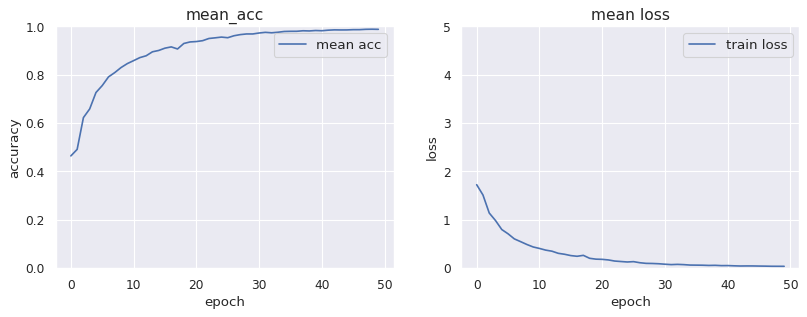

In [ ]:
#出力したテンソルのデバイスをCPUへ切り替える
device2 = torch.device('cpu')


"""
for i in range(epoch):
    mean_acc2 = mean_acc_list[i].to(device)
    mean_acc3 = mean_acc2.clone().numpy()
    mean_acc.append(mean_acc3)
    
    mean_loss2 = mean_loss_list[i].to(device2)
    mean_loss3 = mean_loss2.clone().detach().numpy()
    mean_loss.append(mean_loss3)
"""

#取得したデータをグラフ化する
sns.set()
num_epoch = epoch

fig = plt.subplots(figsize=(12, 4), dpi=80)

ax1 = plt.subplot(1,2,1)
ax1.plot(range(num_epoch), mean_acc_list, c='b', label='mean acc')
ax1.set_xlabel('epoch', fontsize='12')
ax1.set_ylabel('accuracy', fontsize='12')
ax1.set_title('mean_acc', fontsize='14')
ax1.legend(fontsize='12')
plt.ylim(0,1)

ax2 = plt.subplot(1,2,2)
ax2.plot(range(num_epoch), mean_loss_list, c='b', label='train loss')
ax2.set_xlabel('epoch', fontsize='12')
ax2.set_ylabel('loss', fontsize='12')
ax2.set_title('mean loss', fontsize='14')
ax2.legend(fontsize='12')
plt.ylim(0,5)
plt.show()

In [ ]:
import os

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#学習結果の保存
model_path = '/content/gdrive/MyDrive/ResNet50-pretrained-20.pth'
torch.save(model.state_dict(), model_path)

In [ ]:
#学習結果の呼び出し
device=torch.device("cuda:0")
model.load_state_dict(
    torch.load(
        os.path.join( "/content/gdrive/MyDrive/ResNet50-20.pth")
    )
)

<All keys matched successfully>

In [ ]:

# データローダーの準備
test_loader = torch.utils.data.DataLoader(test_data, batch_size=100, shuffle=False)

# ネットワークを評価モードへ変更
model.eval()

# 評価の実行
count = 0
with torch.no_grad():
    for image, label in test_loader:

        if use_cuda:
            image = image.cuda()
            label = label.cuda()
            
        y = model(image)

        pred = torch.argmax(y, dim=1)
        count += torch.sum(pred == label)

print("test accuracy: {}".format(count.item() / len(test_data)))

test accuracy: 0.8363


In [ ]:
from tqdm import tqdm
model.eval()
prob_all = []
label_all = []
prob_score=[]
device=torch.device("cuda")
i=0
for data, label in tqdm(test_loader):
        data = data.to(device)
        label = label.to(device)
        l2 = label.cpu().detach().numpy()
        label_all.extend(l2)
        prob = model(data)
        prob = prob.cpu().detach().numpy()
        prob_score.extend(prob) 
        prob_all.extend(np.argmax(prob,axis=1))
        i=i+1
#print(lable_all)
#print(prob_score)

100%|██████████| 100/100 [00:02<00:00, 39.29it/s]


In [ ]:
print(i)
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve

import torchvision.ops.boxes as bops


print("Accuracy:{:.4f}".format(accuracy_score(label_all, prob_all) ))
print("Recall:{:.4f}".format(recall_score(label_all, prob_all,average='macro') ))
print("Precision:{:.4f}".format(precision_score(label_all, prob_all,average='macro') ))
print("f1_score:{:.4f}".format(f1_score(label_all, prob_all,average='macro') ))
print(classification_report(label_all,prob_all,target_names=classes,digits=4))

#fpr, tpr, thresholds = roc_curve(label_all, prob_score, pos_label=2)
#print("Auc:{:.4f}".format(roc_auc_score(label_all, prob_score,average='macro') ))
print(confusion_matrix(prob_all,label_all))


100
Accuracy:0.8363
Recall:0.8363
Precision:0.8350
f1_score:0.8344
              precision    recall  f1-score   support

       plane     0.8167    0.8780    0.8463      1000
         car     0.9017    0.9170    0.9093      1000
        bird     0.7812    0.8070    0.7939      1000
         cat     0.7482    0.6240    0.6805      1000
        deer     0.8023    0.8480    0.8245      1000
         dog     0.8087    0.7230    0.7635      1000
        frog     0.8422    0.9070    0.8734      1000
       horse     0.8978    0.8520    0.8743      1000
        ship     0.8844    0.9100    0.8970      1000
       truck     0.8667    0.8970    0.8816      1000

    accuracy                         0.8363     10000
   macro avg     0.8350    0.8363    0.8344     10000
weighted avg     0.8350    0.8363    0.8344     10000

[[878  12  36  26  12  13   8  18  48  24]
 [ 11 917   2  16   2   7   3   1  14  44]
 [ 41   3 807  58  30  36  24  22   8   4]
 [  6   0  28 624  28 103  18  18   6   3]
 [

In [ ]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

In [ ]:
print(mean_acc_list)

In [ ]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [ ]:
output = model(X_train)

In [ ]:
from PIL import Image
import random
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from keras.datasets import cifar10

In [ ]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 13s 0us/step


TypeError: ignored

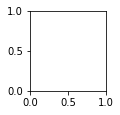

In [ ]:
#評価用
with torch.no_grad():
  pos = 1
#index = 0
  index = random.randint(0, X_test.shape[0]/2)
  i = index

# plt figure set to 16inch x 16inch(1600pixel x 1600 pixel). 
  plt.figure(figsize=(16,5))

# draw cifar10 images and label names
  for img in X_test[index:index+10]:
      plt.subplot(3, 10, pos)
      pos += 1
      i += 1
      #img = Image.fromarray(img)
      """
      img_output = transforms.Compose([
      transforms.Resize((224, 224)), 
      transforms.ToTensor(),
      transforms.Normalize(0.5, 0.5),
      ])(img).unsqueeze(0)
      """
      model=model.cpu()
      outputs = model(img)
      output=outputs.detach().numpy()

      label_max=np.argmax(output)
      pred=torch.max(outputs)
      print('No1.label_name：', classes[int(label_max)]) # 予想ラベル（最も確率の高い要素）
      plt.imshow(img)
      plt.axis('off')
      plt.title(classes[int(label_max)])   
      print('No1.number_pred' , pred)
     

In [ ]:
prob_pred_ResNet = model.predict(X_test)

In [ ]:
#predect_probaがResNetBasicBlockに非対応
pos_prob = model.predict_proba(mean_acc_list)[:, 1]

In [ ]:
roc = roc_curve(X_test, mean_acc_list)

In [ ]:
fpr, tpr, thresholds = roc_curve(y_train, mean_acc_list)

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, proba_lr)
plt.plot(fpr, tpr, color=colors[0], label='logistic')
plt.fill_between(fpr, tpr, 0, color=colors[0], alpha=0.1)

fpr, tpr, thresholds = roc_curve(y_test, proba_rf)
plt.plot(fpr, tpr, color=colors[1], label='random forestss')
plt.fill_between(fpr, tpr, 0, color=colors[1], alpha=0.1)

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()

# AUCの計算
print(f'ロジスティック回帰モデル AUR: {roc_auc_score(y_test, proba_lr):.4f}')
print(f'ランダムフォレストモデル AUR: {roc_auc_score(y_test, proba_rf):.4f}')

In [ ]:
plt.plot(fpr, tpr, marker='o')
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.grid()
plt.savefig('data/dst/sklearn_roc_curve.png')